In [4]:
## Notebook 2: Create new model for every training, train the model as the sliding window for 1 week
## Added new feature: total age and nodes requested for waiting jobs
## In this notebook we use job history data for Mar 2022
## Lookback for queue minutes = 35
## we also added total age of last 35 jobs waiting in the queue as the 'waiting_time' feature vector
## We also added total number of nodes requested by the waiting jobs
## We train the model for one week (i.e 7 days) and then predict queue minutes for the jobs in the 8th day.
## Then we slide the window one day, and then train again for next 7 days and predict the 8th day
## For every training, we create the same model and do the training from the scratch
### Input file : ../data/processed/lookback35_anon_feb1_aug1.csv
### Intermediate file: ../data/processed/lookback35_total_age_nodes_anon_mar_31.csv
## Result file: ../data/processed/nn_sliding_window_lookback35_anon_march_totalage_node22.csv'
### We also tried adding age for each of last 35 waiting jobs. nn-
#### Result is in the file: nn_sliding_window_lookback35_anon_march_age22.csv

In [111]:
import sys
sys.path.append('/home/jovyan/work/')
sys.path.append('/home/jovyan/work/src')
sys.path.append('/home/jovyan/work/src/data')
sys.path.append('/home/jovyan/work/src/data_explore')
sys.path.append('/home/jovyan/work/src/features')
sys.path.append('/home/jovyan/work/src/models')
sys.path.append('/home/jovyan/work/src/analysis')


In [112]:
print(sys.path)

['/home/jovyan/work/notebooks', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis']


In [113]:
from src import data,data_explore,features
from data import create_input_data
from data_explore import explore_util
from features import build_features
from models import train_model,predict_model
from analysis import analyze_pred

import pandas as pd

In [114]:
def get_jobs_in_range(dfq,start,end):
    df1=dfq.query('submit >= @start and submit < @end')
    return df1

In [115]:
# weekly prediction for the month of March
df_arr={}
df_feb_aug1 = create_input_data.read_data(csv_file_name="../data/processed/lookback35_anon_feb1_aug1.csv", parse_dates_col=[4,5,6])

#df_arr['1wee']= get_jobs_in_range(df_feb_aug,"2022-03-01","2022-03-07")
#df_arr['april']= get_jobs_in_range(df_feb_aug,"2022-04-01","2022-05-01")


In [116]:
df_mar = get_jobs_in_range(df_feb_aug1,"2022-03-01", "2022-04-02")
df_mar

,jobid,user,account,state,submit,start,end,reqcpus,nnodes,max_minutes,...,qm26,qm27,qm28,qm29,qm30,qm31,qm32,qm33,qm34,qm35
36043,9224787,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:56,2022-03-01 00:01:57,2022-03-01 00:02:29,1,1,15,...,9,44,34,3,13,13,13,13,34,3
36044,9224788,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:57,2022-03-01 00:02:02,2022-03-01 00:02:34,1,1,15,...,9,44,34,3,13,13,13,13,34,3
36045,9224789,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:57,2022-03-01 00:02:02,2022-03-01 00:02:39,1,1,15,...,9,44,34,3,13,13,13,13,34,3
36046,9224790,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:58,2022-03-01 00:02:02,2022-03-01 00:02:37,1,1,15,...,4,9,44,34,3,13,13,13,13,34
36047,9224791,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:59,2022-03-01 00:02:02,2022-03-01 00:02:36,1,1,15,...,4,9,44,34,3,13,13,13,13,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82874,9389984,82ba7b08c56b4efe2e75671538fb6723b0e0f7750008aa...,bc465ebee2029e944979a0072aac13f7a14ae77ed8143e...,COMPLETED,2022-04-01 23:40:41,2022-04-01 23:40:42,2022-04-02 00:08:56,68,1,360,...,24,25,24,23,24,27,24,28,29,11
82875,9390001,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:48:18,2022-04-01 23:48:19,2022-04-02 00:04:16,125,5,720,...,0,24,25,24,23,24,27,24,28,29
82876,9390004,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:48:55,2022-04-01 23:48:58,2022-04-02 00:00:40,125,5,720,...,23,0,24,25,24,23,24,27,24,28
82877,9390005,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:49:09,2022-04-01 23:49:09,2022-04-02 00:06:53,125,5,720,...,19,23,0,24,25,24,23,24,27,24


In [117]:
df_mar_reset=df_mar.reset_index()
df_mar_reset

,index,jobid,user,account,state,submit,start,end,reqcpus,nnodes,...,qm26,qm27,qm28,qm29,qm30,qm31,qm32,qm33,qm34,qm35
0,36043,9224787,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:56,2022-03-01 00:01:57,2022-03-01 00:02:29,1,1,...,9,44,34,3,13,13,13,13,34,3
1,36044,9224788,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:57,2022-03-01 00:02:02,2022-03-01 00:02:34,1,1,...,9,44,34,3,13,13,13,13,34,3
2,36045,9224789,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:57,2022-03-01 00:02:02,2022-03-01 00:02:39,1,1,...,9,44,34,3,13,13,13,13,34,3
3,36046,9224790,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:58,2022-03-01 00:02:02,2022-03-01 00:02:37,1,1,...,4,9,44,34,3,13,13,13,13,34
4,36047,9224791,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:59,2022-03-01 00:02:02,2022-03-01 00:02:36,1,1,...,4,9,44,34,3,13,13,13,13,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46831,82874,9389984,82ba7b08c56b4efe2e75671538fb6723b0e0f7750008aa...,bc465ebee2029e944979a0072aac13f7a14ae77ed8143e...,COMPLETED,2022-04-01 23:40:41,2022-04-01 23:40:42,2022-04-02 00:08:56,68,1,...,24,25,24,23,24,27,24,28,29,11
46832,82875,9390001,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:48:18,2022-04-01 23:48:19,2022-04-02 00:04:16,125,5,...,0,24,25,24,23,24,27,24,28,29
46833,82876,9390004,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:48:55,2022-04-01 23:48:58,2022-04-02 00:00:40,125,5,...,23,0,24,25,24,23,24,27,24,28
46834,82877,9390005,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:49:09,2022-04-01 23:49:09,2022-04-02 00:06:53,125,5,...,19,23,0,24,25,24,23,24,27,24


In [78]:
df_mar_reset.at[0,"start"]

Timestamp('2022-03-01 00:01:57')

In [118]:
from importlib import reload
reload(create_input_data)
lookback=35
col_name="queue_minutes"

#df_mar_31,rows_to_discard=create_input_data.optimised_add_age_past_k_obs_insert(lookback, df_mar_reset,col_name)
df_mar_31,rows_to_discard=create_input_data.optimised_add_total_age_nodes_past_k_obs_insert(lookback, df_mar_reset,col_name)

*** loopback_count never equals to  lookback. so do not consider the row 0
*** loopback_count never equals to  lookback. so do not consider the row 1
*** loopback_count never equals to  lookback. so do not consider the row 2
*** loopback_count never equals to  lookback. so do not consider the row 3
*** loopback_count never equals to  lookback. so do not consider the row 4
*** loopback_count never equals to  lookback. so do not consider the row 5
*** loopback_count never equals to  lookback. so do not consider the row 6
*** loopback_count never equals to  lookback. so do not consider the row 7
*** loopback_count never equals to  lookback. so do not consider the row 8
*** loopback_count never equals to  lookback. so do not consider the row 9
*** loopback_count never equals to  lookback. so do not consider the row 10
*** loopback_count never equals to  lookback. so do not consider the row 11
*** loopback_count never equals to  lookback. so do not consider the row 12
*** loopback_count nev

In [119]:
df_mar_31

,index,jobid,user,account,state,submit,start,end,reqcpus,nnodes,...,qm28,qm29,qm30,qm31,qm32,qm33,qm34,qm35,nodes,waiting_time
0,36043,9224787,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:56,2022-03-01 00:01:57,2022-03-01 00:02:29,1,1,...,34,3,13,13,13,13,34,3,1,0.000000
1,36044,9224788,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:57,2022-03-01 00:02:02,2022-03-01 00:02:34,1,1,...,34,3,13,13,13,13,34,3,0,0.000000
2,36045,9224789,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:57,2022-03-01 00:02:02,2022-03-01 00:02:39,1,1,...,34,3,13,13,13,13,34,3,0,0.000000
3,36046,9224790,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:58,2022-03-01 00:02:02,2022-03-01 00:02:37,1,1,...,44,34,3,13,13,13,13,34,0,0.000000
4,36047,9224791,fdc43e3f26ed40db965fb370601ef4571e92f0beaeb011...,30c491786127bee5caf0e0f6c784ffb08c5f76a877311e...,COMPLETED,2022-03-01 00:01:59,2022-03-01 00:02:02,2022-03-01 00:02:36,1,1,...,44,34,3,13,13,13,13,34,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46831,82874,9389984,82ba7b08c56b4efe2e75671538fb6723b0e0f7750008aa...,bc465ebee2029e944979a0072aac13f7a14ae77ed8143e...,COMPLETED,2022-04-01 23:40:41,2022-04-01 23:40:42,2022-04-02 00:08:56,68,1,...,24,23,24,27,24,28,29,11,36,199.550000
46832,82875,9390001,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:48:18,2022-04-01 23:48:19,2022-04-02 00:04:16,125,5,...,25,24,23,24,27,24,28,29,36,207.166667
46833,82876,9390004,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:48:55,2022-04-01 23:48:58,2022-04-02 00:00:40,125,5,...,24,25,24,23,24,27,24,28,36,207.783333
46834,82877,9390005,c64d103777a6f927ce7fe26222ae078699ed6e260c0dab...,b7f95d23ae1cdc151a9b08eaf41307365ee010d26a2b40...,COMPLETED,2022-04-01 23:49:09,2022-04-01 23:49:09,2022-04-02 00:06:53,125,5,...,0,24,25,24,23,24,27,24,1,208.033333


In [120]:
# write to file
from pathlib import Path  
filepath = Path('../data/processed/lookback35_total_age_nodes_anon_mar_31.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
df_mar_31.to_csv(filepath,index=False)

In [122]:
## Train 1 week and predict one day
start_train_weeks=[]
end_train_weeks=[]
predict_day=[]
day1 = pd.Timestamp("2022-03-01")
start_train_weeks.append(day1)
#day8 = day1_mar + pd.Timedelta("7 days")
next_week = day1
day2 = day1
for i in range(0,25):
    next_week=next_week + pd.Timedelta("7 days")
    end_train_weeks.append(next_week)
    predict_day.append(next_week)
    day2 = day2 + pd.Timedelta("1 days")
    next_week = day2
    start_train_weeks.append(next_week)
for i in range(0,25):
    print("start: " + str(start_train_weeks[i]) + ": " + str(start_train_weeks[i].day_name()) + " end: " 
          + str(end_train_weeks[i]) + " : " + str(end_train_weeks[i].day_name()))
    print("predict: " + str(predict_day[i].day_name()))

start: 2022-03-01 00:00:00: Tuesday end: 2022-03-08 00:00:00 : Tuesday
predict: Tuesday
start: 2022-03-02 00:00:00: Wednesday end: 2022-03-09 00:00:00 : Wednesday
predict: Wednesday
start: 2022-03-03 00:00:00: Thursday end: 2022-03-10 00:00:00 : Thursday
predict: Thursday
start: 2022-03-04 00:00:00: Friday end: 2022-03-11 00:00:00 : Friday
predict: Friday
start: 2022-03-05 00:00:00: Saturday end: 2022-03-12 00:00:00 : Saturday
predict: Saturday
start: 2022-03-06 00:00:00: Sunday end: 2022-03-13 00:00:00 : Sunday
predict: Sunday
start: 2022-03-07 00:00:00: Monday end: 2022-03-14 00:00:00 : Monday
predict: Monday
start: 2022-03-08 00:00:00: Tuesday end: 2022-03-15 00:00:00 : Tuesday
predict: Tuesday
start: 2022-03-09 00:00:00: Wednesday end: 2022-03-16 00:00:00 : Wednesday
predict: Wednesday
start: 2022-03-10 00:00:00: Thursday end: 2022-03-17 00:00:00 : Thursday
predict: Thursday
start: 2022-03-11 00:00:00: Friday end: 2022-03-18 00:00:00 : Friday
predict: Friday
start: 2022-03-12 00:00

In [123]:
df_predict={}
for i in range(0,24):
    df_arr['week'+ str(i+1)]= get_jobs_in_range(df_mar_31,start_train_weeks[i], end_train_weeks[i])
    df_predict['day'+ str(i+1)] = get_jobs_in_range(df_mar_31,predict_day[i], predict_day[i+1])

In [124]:
week_names=[]
for i in range(0,24):
    week_names.append('week'+str(i+1))
print(week_names)    

['week1', 'week2', 'week3', 'week4', 'week5', 'week6', 'week7', 'week8', 'week9', 'week10', 'week11', 'week12', 'week13', 'week14', 'week15', 'week16', 'week17', 'week18', 'week19', 'week20', 'week21', 'week22', 'week23', 'week24']


In [125]:
df_arr['week23']

,index,jobid,user,account,state,submit,start,end,reqcpus,nnodes,...,qm28,qm29,qm30,qm31,qm32,qm33,qm34,qm35,nodes,waiting_time
31446,67489,9335886,a9b48add36b60f2f72e94366fb9bf6baab32cdf635f4a7...,d5d76a6633132cbeb3708f31126c7ed943ff988ccaaa67...,COMPLETED,2022-03-23 00:08:30,2022-03-23 04:48:14,2022-03-24 20:03:10,24,1,...,0,0,0,63,2,6,73,74,32,159.883333
31447,67490,9335888,198adb7cee4a179c48a896ae776be358cfb45d615c11df...,65c812caf3c7dd6c293c81a86410b39b41ab4e3b1c80e8...,COMPLETED,2022-03-23 00:10:36,2022-03-23 00:19:25,2022-03-23 01:40:29,1,1,...,0,0,0,63,2,6,73,74,1,151.783333
31448,67491,9335893,a317341f990c02a0e6b744b11612df2a22d5c700a51fde...,379c458040571502e6654cf29eb59b188100cff9862076...,COMPLETED,2022-03-23 00:16:13,2022-03-23 00:16:31,2022-03-23 00:24:07,1,1,...,0,0,0,63,2,6,73,74,4,152.133333
31449,67492,9335916,25bdfe23b72476c7341a5c05c37ad40427e6011e8ada21...,379c458040571502e6654cf29eb59b188100cff9862076...,COMPLETED,2022-03-23 00:23:52,2022-03-23 00:24:24,2022-03-23 00:24:44,2,1,...,8,0,0,0,0,63,2,6,1,165.050000
31450,67493,9335921,0d829adc3af512b488fbe9717f19c274ab68668808dc3b...,7d5932a6968147c74b21f73d81e35d84dae2a372bd55ea...,COMPLETED,2022-03-23 00:24:44,2022-03-23 04:48:07,2022-03-23 07:22:01,130,2,...,13,8,0,0,0,0,63,2,1,165.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41418,77461,9371593,414ad679b891009c427106612bcc666435e62cebaa2844...,1940ae389c4d976607715c6b9c735c580c89a515c56029...,COMPLETED,2022-03-29 23:50:16,2022-03-30 00:10:37,2022-03-30 00:14:54,1,1,...,0,0,86,0,71,0,0,2,4,87.166667
41419,77462,9371594,414ad679b891009c427106612bcc666435e62cebaa2844...,1940ae389c4d976607715c6b9c735c580c89a515c56029...,COMPLETED,2022-03-29 23:50:18,2022-03-30 00:10:37,2022-03-30 00:16:27,1,1,...,0,0,86,0,71,0,0,2,4,79.916667
41420,77463,9371595,414ad679b891009c427106612bcc666435e62cebaa2844...,1940ae389c4d976607715c6b9c735c580c89a515c56029...,COMPLETED,2022-03-29 23:50:20,2022-03-30 00:10:37,2022-03-30 00:18:29,1,1,...,0,0,86,0,71,0,0,2,4,73.850000
41421,77464,9371600,b988b5837c24ad1987f31266e0246b0fdaaf7948714cfa...,5f68f9d9f201b927371597c8c907cf3e9ab6fd33d6441c...,COMPLETED,2022-03-29 23:55:20,2022-03-29 23:55:20,2022-03-29 23:55:42,62,2,...,0,0,86,0,71,0,0,2,4,78.850000


In [126]:
df_predict['day1']

,index,jobid,user,account,state,submit,start,end,reqcpus,nnodes,...,qm28,qm29,qm30,qm31,qm32,qm33,qm34,qm35,nodes,waiting_time
8479,44522,9264440,1e94032cb929373ffe8edc8761fcf62741fc8312d6140d...,e518824e2cd46680ad7e25759f168bb4affb5afbffb5b0...,COMPLETED,2022-03-08 00:00:56,2022-03-08 06:15:04,2022-03-09 10:39:33,120,5,...,0,0,0,0,0,0,0,0,4,15.300000
8480,44523,9264443,5315c0d39d9b80958306da0d58d4c80f23511dbf320c59...,13f12669b2c1d64b36b4333e0df18511fec7136beb13a9...,COMPLETED,2022-03-08 00:03:05,2022-03-08 00:39:52,2022-03-08 02:37:27,256,4,...,14,14,14,14,14,14,14,6,1,51.900000
8481,44524,9264453,41d85cea6d357d42e23d07231155f073580245cef425a1...,c171b107c6f21114432f6b057a4911169e3df44f35e38a...,COMPLETED,2022-03-08 00:06:22,2022-03-08 06:15:29,2022-03-08 09:32:32,1,1,...,14,14,14,14,14,14,14,14,1,55.183333
8482,44525,9264493,ea61bb2d95cf16714cedc5e4ec63ffbc5834968418511c...,1d4712c264238a06f8d4af03724155dc82e877f41430eb...,COMPLETED,2022-03-08 00:18:44,2022-03-08 01:38:42,2022-03-08 02:42:35,68,1,...,17,17,17,17,17,14,14,14,1,69.116667
8483,44526,9264494,ea61bb2d95cf16714cedc5e4ec63ffbc5834968418511c...,1d4712c264238a06f8d4af03724155dc82e877f41430eb...,COMPLETED,2022-03-08 00:19:07,2022-03-08 01:38:42,2022-03-08 03:15:25,68,1,...,17,17,17,17,17,14,14,14,1,69.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9826,45869,9269007,645c687165564fa805fd7245fbb41102cb3ccc1d45aac5...,ba26d9b434c5fa30f5fee7024a1a70f0e30f44be856ed8...,COMPLETED,2022-03-08 23:37:00,2022-03-09 03:02:49,2022-03-09 03:12:16,256,8,...,0,19,17,3,22,18,13,79,2,4.516667
9827,45870,9269008,645c687165564fa805fd7245fbb41102cb3ccc1d45aac5...,ba26d9b434c5fa30f5fee7024a1a70f0e30f44be856ed8...,COMPLETED,2022-03-08 23:37:06,2022-03-09 03:03:24,2022-03-09 03:20:02,256,8,...,0,19,17,3,22,18,13,79,2,3.900000
9828,45871,9269017,100dd935adb232830f84e5a1a9ce5540deeffb477b5205...,8d798419e042f4a78bfa4af0adbeb70aab558ae3ad0209...,COMPLETED,2022-03-08 23:40:18,2022-03-08 23:45:50,2022-03-08 23:54:54,10,1,...,0,2,0,19,17,3,22,18,2,7.100000
9829,45872,9269048,ea61bb2d95cf16714cedc5e4ec63ffbc5834968418511c...,1d4712c264238a06f8d4af03724155dc82e877f41430eb...,COMPLETED,2022-03-08 23:54:42,2022-03-09 02:38:21,2022-03-09 09:06:48,252,4,...,0,0,9,0,18,1,9,20,2,21.500000


In [127]:
def train_test_data(month,df_arr):
    X_historydata = df_arr[month]
    ## remove default columns
    df = build_features.remove_default_cols(df_arr[month])
    Y_waittimedata = df['queue_minutes']
    X_historydata= build_features.remove_cols(df,['index','queue_minutes','run_minutes'])
    return X_historydata, Y_waittimedata

In [24]:
# from sklearn.linear_model import LinearRegression
# def train_model_LR(X_historydata_norm, Y_waittimedata_train):
#     lreg = LinearRegression().fit(X_historydata_norm, Y_waittimedata_train)
#     model_score = lreg.score(X_historydata_norm, Y_waittimedata_train)
#     return lreg, model_score

In [128]:
from importlib import reload
reload(train_model)
def train_model_NN(X_historydata_norm, Y_waittimedata_train):
    epochs=500
    batch_size=32
    validation_spilt=0.2
    model = train_model.create_default_model(input_shape=44)
    early_stopping_cb = train_model.set_early_stopping()
    model, hist = train_model.train_model_no_shuffle(X_historydata_norm, Y_waittimedata_train, model, early_stopping_cb,epochs=epochs, batch_size=batch_size, validation_spilt=0.2)
    return model, hist

In [129]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test):
    y_pred=model.predict(scaler.transform(X_historydata_test))
    y_pred = np.where(y_pred<0,0,y_pred)
    r2s = r2_score(Y_waittimedata_test.to_numpy(),y_pred)
    mse = mean_squared_error(Y_waittimedata_test.to_numpy(),y_pred,squared=False)
    mae = mean_absolute_error(Y_waittimedata_test.to_numpy(),y_pred)
    return y_pred, r2s, mse, mae

In [130]:
from importlib import reload
reload(analyze_pred)
reload(build_features)


<module 'features.build_features' from '/home/jovyan/work/src/features/build_features.py'>

In [131]:
from importlib import reload
import numpy as np
reload(analyze_pred)
reload(build_features)
reload(train_model)
results=[]
for i in range(0,24):
    result = {}
    result['train_week']= start_train_weeks[i]
    result['predict_day']= predict_day[i]
    X_historydata_train, Y_waittimedata_train = train_test_data(week_names[i],df_arr)
    X_historydata_test, Y_waittimedata_test = train_test_data('day'+str(i+1),df_predict)
    X_historydata_norm, scaler = build_features.standardization(X_historydata_train)
    
    model, hist = train_model_NN(X_historydata_norm, Y_waittimedata_train)
    model_metrics = predict_model.compare_metrics(model,scaler,X_historydata_test, Y_waittimedata_test)
    y_pred, r2s, mse, mae = predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test)
    provision_time = 20
    tolerance_factor = 3
    provision_time, n_scheduled, n_missed, no_missed, wrongly_scheduled, t_num = analyze_pred.analysis_short(0,Y_waittimedata_test.shape[0], Y_waittimedata_test, y_pred.ravel(),
                                                                                                          provision_time=provision_time, tolerance_factor=tolerance_factor)
    
    result['ideally_sched'] = n_scheduled
    result['missed'] = n_missed

    result['wrongly_sched'] = wrongly_scheduled
    result['total_num'] = t_num
    result['%_wrongly_sched'] = (wrongly_scheduled/t_num)*100
    result['%_ideally_sched'] = (n_scheduled/t_num)*100
    result['%_missed_opp.'] = (n_missed/n_scheduled)*100
    result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100
    result['r2s'] = r2s
    result['mse'] = mse
    result['mae'] = mae
    result['model_mae'] = model_metrics['mae']
    result['model_mse'] = model_metrics['loss']
    #result['model'] = lreg
    result['y_pred'] = y_pred
    #result['not_missed'] = no_missed
    #result['provision_time'] = provision_time
    results.append(result)
    #print(result)
    #print("\n")


Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 30)                1350      
                                                                 
 Hidden2 (Dense)             (None, 100)               3100      
                                                                 
 Hidden3 (Dense)             (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 14,651
Trainable params: 14,651
Non-trainable params: 0
_________________________________________________________________
None
43/43 [==============================] - 0s 547us/step - loss: 28250.3398 - mae: 136.5968
loss — -> 28250.33984375
mae — -> 136.59677124023438
43/43 [==============================

In [132]:
reload(analyze_pred)
rdf = analyze_pred.add_all_to_df(results)

In [133]:
rdf

,train_week,predict_day,ideally_sched,missed,wrongly_sched,total_num,%_wrongly_sched,%_ideally_sched,%_missed_opp.,t_wrong_sched_%,r2s,mse,mae,model_mae,model_mse,y_pred
0,2022-03-01,2022-03-08,691,2,637,1352,47.115385,51.109467,0.289436,48.039216,0.353047,168.078375,136.596769,136.596771,2.825034e+04,"[[627.3401], [164.35718], [587.5265], [165.807..."
1,2022-03-02,2022-03-09,953,0,2220,3437,64.591213,27.727669,0.000000,69.965332,-0.119569,183.373463,92.638054,92.689491,3.362593e+04,"[[148.6019], [96.02188], [99.70715], [480.3927..."
2,2022-03-03,2022-03-10,905,814,42,3152,1.332487,28.711929,89.944751,31.578947,-0.285826,132.508516,68.917995,630.139648,7.640332e+05,"[[465.95352], [179.3544], [527.2541], [527.788..."
3,2022-03-04,2022-03-11,899,31,1308,2954,44.278944,30.433311,3.448276,60.110294,0.327154,199.393869,89.918233,89.944420,3.976061e+04,"[[157.78242], [32.934624], [44.264637], [180.4..."
4,2022-03-05,2022-03-12,461,2,576,1043,55.225312,44.199425,0.433839,55.652174,0.251516,165.927304,132.396172,132.396790,2.753201e+04,"[[217.0507], [216.3521], [334.8133], [217.3909..."
5,2022-03-06,2022-03-13,401,12,168,678,24.778761,59.144543,2.992519,30.161580,0.377843,176.270108,140.308972,140.308990,3.107115e+04,"[[429.4009], [33.4396], [524.4512], [541.3923]..."
6,2022-03-07,2022-03-14,727,82,63,1471,4.282801,49.422162,11.279230,8.898305,0.087684,754.261639,150.049134,150.210068,5.689146e+05,"[[541.3652], [568.3275], [550.5239], [541.7309..."
7,2022-03-08,2022-03-15,768,27,486,1533,31.702544,50.097847,3.515625,39.608802,0.027014,1794.248114,309.174990,309.175018,3.219327e+06,"[[493.40207], [48.821312], [329.40625], [411.0..."
8,2022-03-09,2022-03-16,693,0,341,1047,32.569245,66.189112,0.000000,32.978723,0.206685,426.642704,361.239946,361.239899,1.820240e+05,"[[510.42023], [275.1972], [534.35626], [276.09..."
9,2022-03-10,2022-03-17,529,0,247,777,31.788932,68.082368,0.000000,31.829897,0.360417,343.341998,295.495039,295.495056,1.178838e+05,"[[667.3598], [853.2886], [602.80383], [1050.91..."


In [150]:
# write to file
from pathlib import Path  
filepath = Path('../data/processed/nn_sliding_window_lookback35_anon_march_totalage_node22.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
rdf.to_csv(filepath,index=False)

(array([19060., 19064., 19068., 19072., 19076., 19080., 19083.]),
 [Text(19060.0, 0, '2022-03-09'),
  Text(19064.0, 0, '2022-03-13'),
  Text(19068.0, 0, '2022-03-17'),
  Text(19072.0, 0, '2022-03-21'),
  Text(19076.0, 0, '2022-03-25'),
  Text(19080.0, 0, '2022-03-29'),
  Text(19083.0, 0, '2022-04-01')])

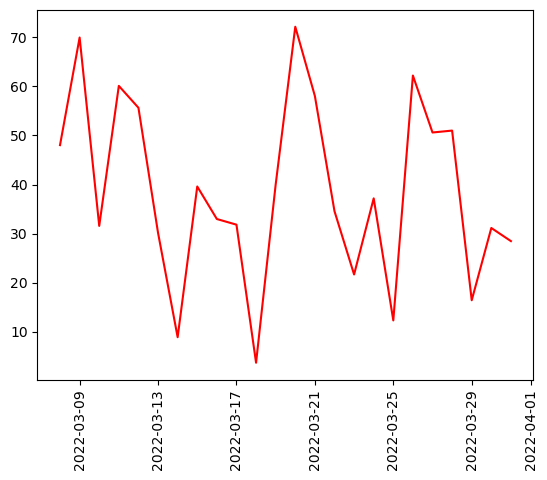

In [135]:
t_wrong_sched= [] 


for i in range(0,24):
    t_wrong_sched.append(results[i]['t_wrong_sched_%'])
plt.plot(predict_day[0:24],t_wrong_sched,'r')
plt.xticks(rotation=90)


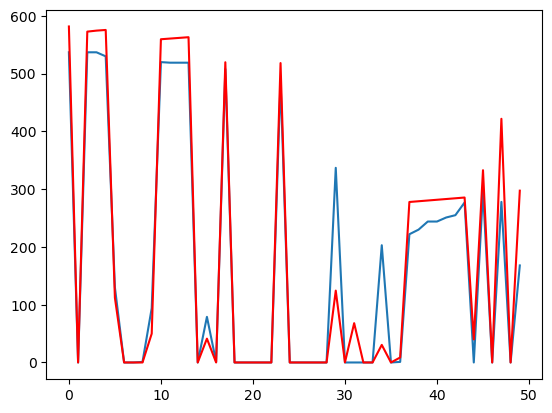

In [136]:
import matplotlib.pyplot as plt
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[10]['y_pred'][150:200],'r')

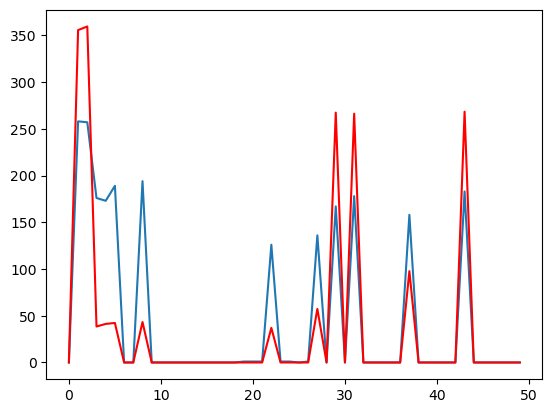

In [137]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[200:250])
plt.plot(results[10]['y_pred'][200:250],'r')

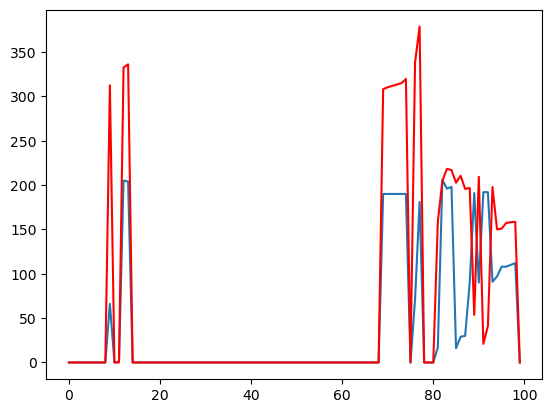

In [138]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[250:350])
plt.plot(results[10]['y_pred'][250:350],'r')

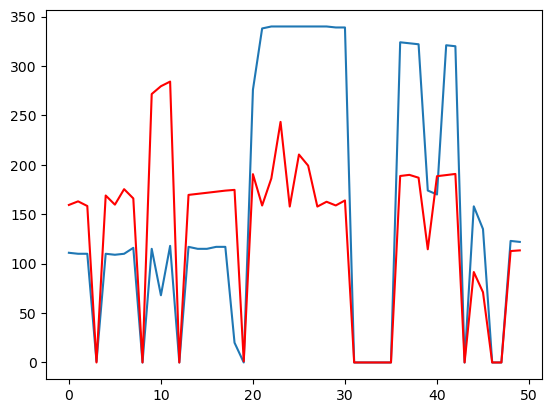

In [139]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[350:400])
plt.plot(results[10]['y_pred'][350:400],'r')

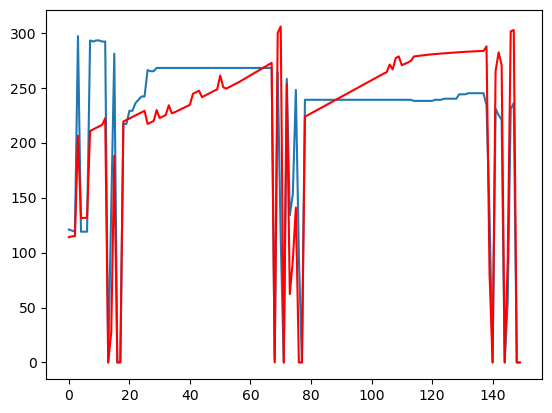

In [140]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[400:550])
plt.plot(results[10]['y_pred'][400:550],'r')

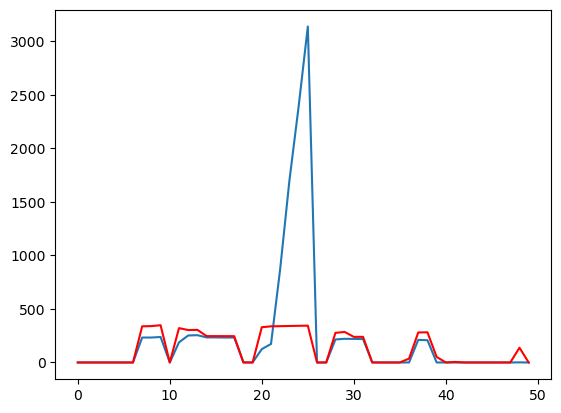

In [141]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[550:600])
plt.plot(results[10]['y_pred'][550:600],'r')

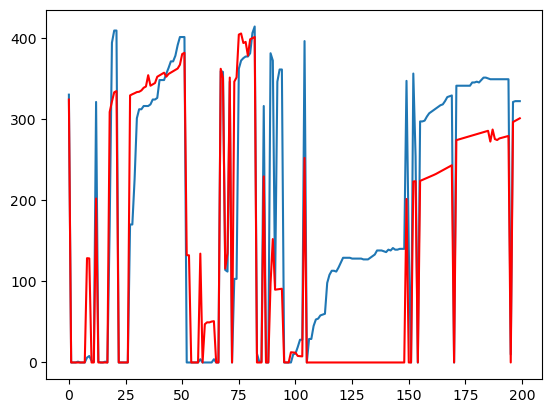

In [142]:
plt.plot(df_predict['day11']['queue_minutes'].to_numpy()[600:800])
plt.plot(results[10]['y_pred'][600:800],'r')

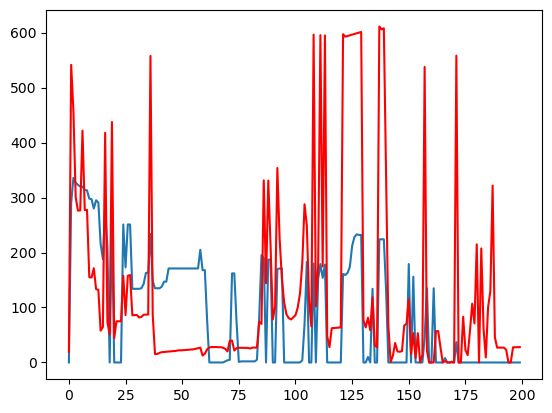

In [143]:
plt.plot(df_predict['day12']['queue_minutes'].to_numpy()[0:200])
plt.plot(results[11]['y_pred'][0:200],'r')

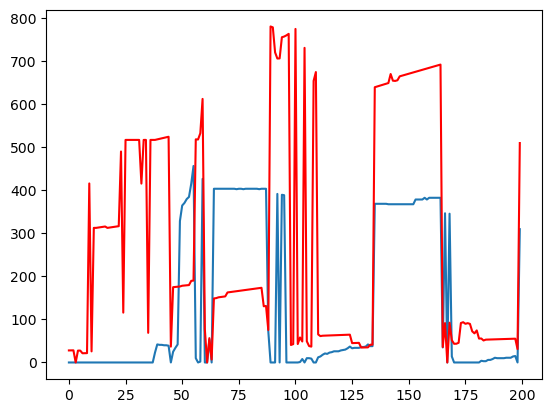

In [144]:
plt.plot(df_predict['day12']['queue_minutes'].to_numpy()[200:400])
plt.plot(results[11]['y_pred'][200:400],'r')

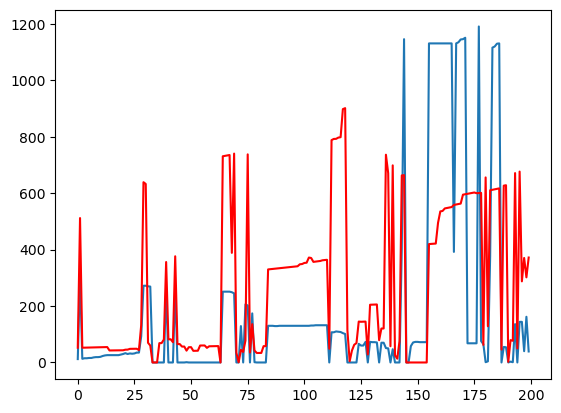

In [145]:
plt.plot(df_predict['day12']['queue_minutes'].to_numpy()[400:600])
plt.plot(results[11]['y_pred'][400:600],'r')

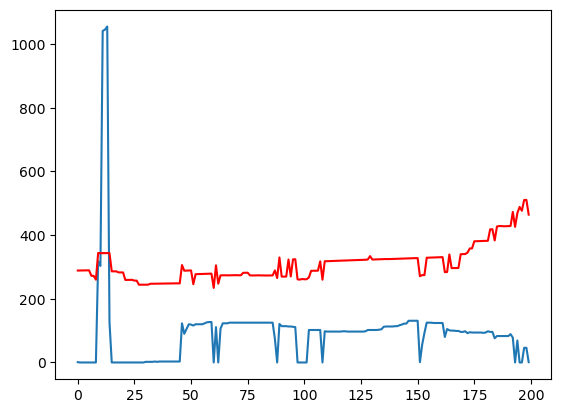

In [146]:
plt.plot(df_predict['day13']['queue_minutes'].to_numpy()[0:200])
plt.plot(results[12]['y_pred'][0:200],'r')

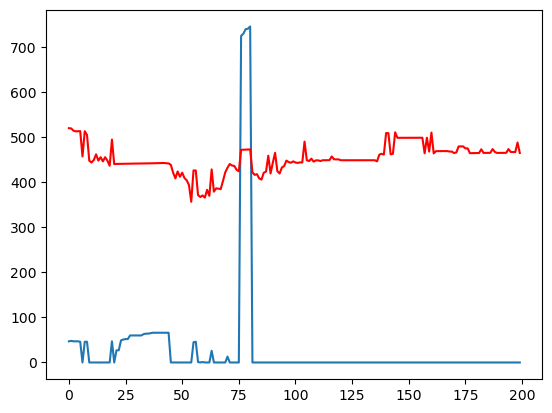

In [147]:
plt.plot(df_predict['day13']['queue_minutes'].to_numpy()[200:400])
plt.plot(results[12]['y_pred'][200:400],'r')

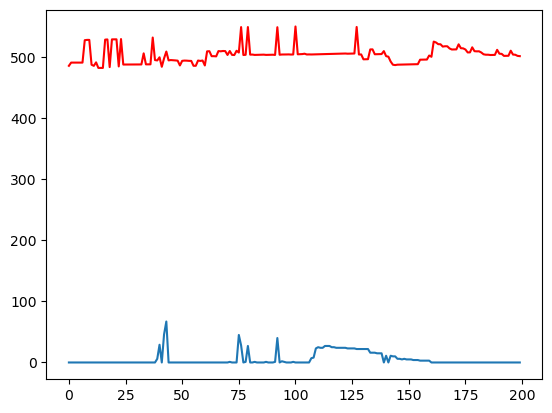

In [148]:
plt.plot(df_predict['day13']['queue_minutes'].to_numpy()[400:600])
plt.plot(results[12]['y_pred'][400:600],'r')

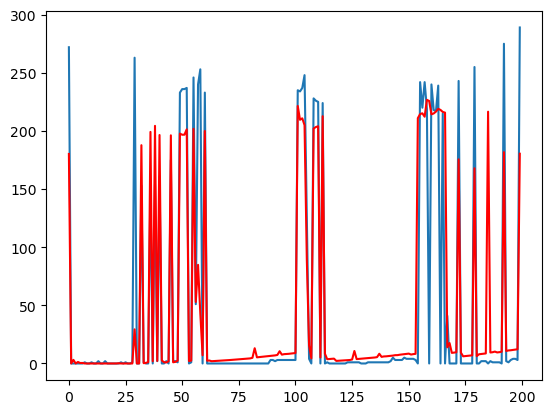

In [149]:
plt.plot(df_predict['day24']['queue_minutes'].to_numpy()[0:200])
plt.plot(results[23]['y_pred'][0:200],'r')